In [1]:
#!/usr/bin/env python
# encoding: utf-8
'''
@license: (C) Copyright 2021, Hey.
@author: Hey
@email: sanyuan.hy@alibaba-inc.com
@tel: 137****6540
@datetime: 2023/4/9 13:46
@project: LucaPCycle
@file: file operator
@desc: file operator
'''
import os
import csv, sys
import io, textwrap, itertools
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
csv.field_size_limit(sys.maxsize)

common_amino_acid_set = {'R', 'X', 'S', 'G', 'W', 'I', 'Q', 'A', 'T', 'V', 'K', 'Y', 'C', 'N', 'L', 'F', 'D', 'M', 'P', 'H', 'E'}


def clean_seq(protein_id, seq):
    seq = seq.upper()
    new_seq = ""
    has_invalid_char = False
    invalid_char_set = set()
    for ch in seq:
        if 'A' <= ch <= 'Z' and ch not in ['J']:
            new_seq += ch
        else:
            invalid_char_set.add(ch)
            has_invalid_char = True
    if has_invalid_char:
        print("id: %s. Seq: %s" % (protein_id, seq))
        print("invalid char set:", invalid_char_set)
    return new_seq


def file_reader(filename, header=True, header_filter=True):
    if filename.endswith(".fa") or filename.endswith(".fas") or filename.endswith(".fasta"):
        return fasta_reader(filename)
    elif filename.endswith(".csv"):
        return csv_reader(filename, header=True, header_filter=True)
    elif filename.endswith(".tsv"):
        return tsv_reader(filename, header=True, header_filter=True)
    else:
        return txt_reader(filename, header=header, header_filter=header_filter)


def txt_reader(handle, header=True, header_filter=True):
    '''
    csv 读取器，适合大文件
    :param handle:
    :param header:
    :param header_filter: 返回结果是否去掉头
    :return:
    '''
    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'r')
    try:
        cnt = 0
        for line in handle:
            cnt += 1
            if header and header_filter and cnt == 1:
                continue
            yield line.strip()
    except Exception as e:
        raise StopIteration
    finally:
        if not handle.closed:
            handle.close()


def tsv_reader(handle, header=True, header_filter=True):
    '''
    csv 读取器，适合大文件
    :param handle:
    :param header:
    :param header_filter: 返回结果是否去掉头
    :return:
    '''
    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'r')
    try:
        reader = csv.reader(handle, delimiter="\t")
        cnt = 0
        for row in reader:
            cnt += 1
            if header and header_filter and cnt == 1:
                continue
            yield row
    except Exception as e:
        raise StopIteration
    finally:
        if not handle.closed:
            handle.close()


def csv_reader(handle, header=True, header_filter=True):
    '''
    csv 读取器，适合大文件
    :param handle:
    :param header:
    :param header_filter: 返回结果是否去掉头
    :return:
    '''
    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'r')
    try:
        # data = csv.reader((line.replace('\0','') for line in data_initial), delimiter=",")
        # reader = csv.reader(handle)
        reader = csv.reader((line.replace('\0', '') for line in handle))
        cnt = 0
        for row in reader:
            cnt += 1
            if header and header_filter and cnt == 1:
                continue
            yield row
    except Exception as e:
        raise StopIteration
    finally:
        if not handle.closed:
            handle.close()


def txt_writer(dataset, handle, header=None):
    '''
    txt 写
    :param dataset: 数据
    :param handle: 文件
    :param header: 头
    :return:
    '''
    with open(handle, "w") as wfp:
        if header:
            if isinstance(header, list):
                wfp.write(",".join(header) + "\n")
            else:
                wfp.write(header + "\n")
        for row in dataset:
            wfp.write(str(row) + "\n")


def csv_writer(dataset, handle, header):
    '''
    csv 写，适合大文件
    :param dataset: 数据
    :param handle: 文件
    :param header: 头
    :return:
    '''
    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'w')
    try:
        writer = csv.writer(handle)
        if header:
            writer.writerow(header)
        for row in dataset:
            writer.writerow(row)
    except Exception as e:
        raise e
    finally:
        if not handle.closed:
            handle.close()


def tsv_writer(dataset, handle, header):
    '''
    tsv 写，适合大文件
    :param dataset: 数据
    :param handle: 文件
    :param header: 头
    :return:
    '''
    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'w')
    try:
        writer = csv.writer(handle, delimiter="\t")
        if header:
            writer.writerow(header)
        for row in dataset:
            writer.writerow(row)
    except Exception as e:
        raise e
    finally:
        if not handle.closed:
            handle.close()

def fasta_reader(handle, width=None):
    """
    Reads a FASTA file, yielding header, sequence pairs for each sequence recovered 适合大文件
    args:
        :handle (str, pathliob.Path, or file pointer) - fasta to read from
        :width (int or None) - formats the sequence to have max `width` character per line.
                               If <= 0, processed as None. If None, there is no max width.
    yields:
        :(header, sequence) tuples
    returns:
        :None
    """
    FASTA_STOP_CODON = "*"

    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'r')
    width = width if isinstance(width, int) and width > 0 else None
    try:
        header = None
        for is_header, group in itertools.groupby(handle, lambda line: line.startswith(">")):
            if is_header:
                header = group.__next__().strip()
            else:
                seq = ''.join(line.strip() for line in group).strip().rstrip(FASTA_STOP_CODON)
                if width is not None:
                    seq = textwrap.fill(seq, width)
                yield header, seq
    except Exception as e:
        raise StopIteration
    finally:
        if not handle.closed:
            handle.close()


def write_fasta(filepath, sequences):
    '''
    write fasta file
    :param filepath: savepath
    :param sequences: fasta sequence(each item: [id, seq])
    :return:
    '''

    if sequences:
        with open(filepath, "w") as output_handle:
            if len(sequences[0]) > 1 and isinstance(sequences[0][0], str):
                for row in sequences:
                    protein_id = row[0]
                    seq = row[1]
                    sequence = SeqRecord(Seq(seq, None), id=protein_id[1:] if protein_id and protein_id[0] == ">" else protein_id, description="")
                    SeqIO.write(sequence, output_handle, "fasta")
            else:
                for sequence in sequences:
                    SeqIO.write(sequence, output_handle, "fasta")


In [2]:
# AI预测初始：
all_ai_predicted_seq_id_set = set()
all_ai_predicted_data_set = {}
for row in csv_reader("./LucaPCycleV3/lucapcycle_v3_init.ids.labels", header=True, header_filter=True):
    seq_id = row[0]
    if seq_id[0] == ">":
        seq_id = seq_id[1:]
    all_ai_predicted_seq_id_set.add(seq_id)
    if seq_id not in all_ai_predicted_data_set:
        all_ai_predicted_data_set[seq_id] = []
    all_ai_predicted_data_set[seq_id].append([seq_id, *row[1:]])

# AI预测的总数(未验证的)
print("AI predicted seq_ids size: %d" % len(all_ai_predicted_seq_id_set))
print("AI predicted data size(seq_id unique): %d" % len(all_ai_predicted_data_set))

# AI预测校验后的：
all_ai_predicted_verify_seq_id_set = set()
all_ai_verify_data_set = {}
for row in csv_reader("./LucaPCycleV3/lucapcycle_v3_2_classes_verified.ids.labels", header=True, header_filter=True):
    seq_id = row[0]
    if seq_id[0] == ">":
        seq_id = seq_id[1:]
    all_ai_predicted_verify_seq_id_set.add(seq_id)
    if seq_id not in all_ai_verify_data_set:
        all_ai_verify_data_set[seq_id] = []
    all_ai_verify_data_set[seq_id].append([seq_id, *row[1:]])
    
all_ai_predicted_verify_seq_id_set = all_ai_predicted_seq_id_set & all_ai_predicted_verify_seq_id_set
all_ai_predicted_error_seq_id_set = all_ai_predicted_seq_id_set - all_ai_predicted_verify_seq_id_set
# AI预测的验证后的总数
print("AI verify seq_ids size: %d" % len(all_ai_predicted_verify_seq_id_set))
# AI预测的错误的总数
print("AI error seq_ids size: %d" % len(all_ai_predicted_error_seq_id_set))
# AI预测的准确率
print("AI acc: (%d/%d)=%f" % (len(all_ai_predicted_verify_seq_id_set), len(all_ai_predicted_seq_id_set), len(all_ai_predicted_verify_seq_id_set)/len(all_ai_predicted_seq_id_set)))
assert len(all_ai_predicted_seq_id_set | all_ai_predicted_verify_seq_id_set) == len(all_ai_predicted_seq_id_set)
assert len(all_ai_predicted_seq_id_set & all_ai_predicted_verify_seq_id_set) == len(all_ai_predicted_verify_seq_id_set)
print("-" * 60)


# Blastp预测的总数(未验证的)
all_blastp_predicted_seq_id_set = set()
all_blastp_predicted_data_set = {}
for row in tsv_reader("./Blastp/blastp_init.ids.labels", header=True, header_filter=True):
    seq_id = row[0]
    if seq_id[0] == ">":
        seq_id = seq_id[1:]
    all_blastp_predicted_seq_id_set.add(seq_id)
    if seq_id not in all_blastp_predicted_data_set:
        all_blastp_predicted_data_set[seq_id] = []
    all_blastp_predicted_data_set[seq_id].append([seq_id, *row[1:]])

print("Blastp predicted seq_ids size: %d" % len(all_blastp_predicted_seq_id_set))
print("Blastp predicted data size: %d" % len(all_blastp_predicted_data_set))

# Blastp预测校验后的：
all_blastp_verify_seq_id_set = set()
all_blastp_verify_data_set = {}
for row in csv_reader("./Blastp/blastp_2_classes_verified.ids.labels", header=True, header_filter=True):
    seq_id = row[0]
    if seq_id[0] == ">":
        seq_id = seq_id[1:]
    all_blastp_verify_seq_id_set.add(seq_id)
    if seq_id not in all_blastp_verify_data_set:
        all_blastp_verify_data_set[seq_id] = []
    all_blastp_verify_data_set[seq_id].append([seq_id, *row[1:]])
    
all_blastp_verify_seq_id_set = all_blastp_predicted_seq_id_set & all_blastp_verify_seq_id_set
all_blastp_error_seq_id_set = all_blastp_predicted_seq_id_set - all_blastp_verify_seq_id_set
# Blastp预测的验证后的总数
print("Blastp verify seq_ids size: %d" % len(all_blastp_verify_seq_id_set))
# Blastp预测的错误的总数
print("Blastp error seq_ids size: %d" % (len(all_blastp_error_seq_id_set)))
# Blastp预测的准确率
print("Blastp acc: (%d/%d)=%f" % (len(all_blastp_verify_seq_id_set), len(all_blastp_predicted_seq_id_set), len(all_blastp_verify_seq_id_set)/len(all_blastp_predicted_seq_id_set)))
assert len(all_blastp_verify_seq_id_set | all_blastp_predicted_seq_id_set) == len(all_blastp_predicted_seq_id_set)
assert len(all_blastp_verify_seq_id_set & all_blastp_predicted_seq_id_set) == len(all_blastp_verify_seq_id_set)
print("-" * 60)

# kofamscan
# 去重的seq_id
all_kofamscan_predicted_seq_id_set = set()
# 所有的seq_id
all_kofamscan_predicted_seq_ids = []
# 每个seq_id的预测记录
all_kofamscan_predicted_repeat = {}
# 预测记录
all_kofamscan_predicted_data_set = {}
for row in tsv_reader("./KofamScan/kofamscan_init.ids.labels", header=True, header_filter=True):
    seq_id = row[0]
    if seq_id[0] == ">":
        seq_id = seq_id[1:]
    all_kofamscan_predicted_seq_ids.append(seq_id)
    if seq_id not in all_kofamscan_predicted_repeat:
        all_kofamscan_predicted_repeat[seq_id] = []
    all_kofamscan_predicted_repeat[seq_id].append(row[1])
    all_kofamscan_predicted_seq_id_set.add(seq_id)
    if seq_id not in all_kofamscan_predicted_data_set:
        all_kofamscan_predicted_data_set[seq_id] = []
    all_kofamscan_predicted_data_set[seq_id].append([seq_id, *row[1:]])
    
# 只留下超过1条记录的seq_ids
new_all_kofamscan_predicted_repeat = {}
for item in all_kofamscan_predicted_repeat.items():
    if len(item[1]) > 1:
        new_all_kofamscan_predicted_repeat[item[0]] = item[1]

# Kofamscan预测的总数(未验证的)
print("Kofamscan predicted seq_ids size: %d" % len(all_kofamscan_predicted_seq_ids))
# Kofamscan预测的seq_id去重总数(未验证的, 因为存在同一个序列有31类标签中的多个标签)
print("Kofamscan predicted seq_ids size(seq_id unique): %d" % len(all_kofamscan_predicted_seq_id_set))
# Kofamscan预测的序列id总数(未验证的)
print("Kofamscan predicted data size(seq_id unique): %d" % len(all_kofamscan_predicted_data_set))
# Kofamscan预测的重复的记录个数(未验证的）
print("Kofamscan repeat: %d" % len(new_all_kofamscan_predicted_repeat))

all_kofamscan_verify_seq_ids = []
all_kofamscan_verify_seq_id_set = set()
all_kofamscan_verify_data_set = {}
for row in csv_reader("./KofamScan/kofamscan_2_classes_verified.ids.labels", header=True, header_filter=True):
    seq_id = row[0]
    if seq_id[0] == ">":
        seq_id = seq_id[1:]
    all_kofamscan_verify_seq_ids.append(seq_id)
    all_kofamscan_verify_seq_id_set.add(seq_id)
    if seq_id not in all_kofamscan_verify_data_set:
        all_kofamscan_verify_data_set[seq_id] = []
    all_kofamscan_verify_data_set[seq_id].append([seq_id, *row[1:]])
    
all_kofamscan_verify_seq_id_set = all_kofamscan_predicted_seq_id_set & all_kofamscan_verify_seq_id_set
all_kofamscan_error_seq_id_set = all_kofamscan_predicted_seq_id_set - all_kofamscan_verify_seq_id_set
# Kofamscan预测的验证后的总数
print("Kofamscan verify seq_ids size: %d" % len(all_kofamscan_verify_seq_id_set))
print("Kofamscan verify data size: %d" % len(all_kofamscan_verify_data_set))
# Kofamscan预测的错误的总数
print("Kofamscan err seq_ids size: %d" % (len(all_kofamscan_error_seq_id_set)))
# Kofamscan预测的准确率(不去重)
print("Kofamscan acc: (%d/%d)=%f" % (len(all_kofamscan_verify_seq_ids), len(all_kofamscan_predicted_seq_ids), len(all_kofamscan_verify_seq_ids)/len(all_kofamscan_predicted_seq_ids)))
# Kofamscan预测的准确率(去重)
print("Kofamscan acc(unique): (%d/%d)=%f" % (len(all_kofamscan_verify_seq_id_set), len(all_kofamscan_predicted_seq_id_set), len(all_kofamscan_verify_seq_id_set)/len(all_kofamscan_predicted_seq_id_set)))
assert len(all_kofamscan_verify_seq_id_set & all_kofamscan_predicted_seq_id_set) == len(all_kofamscan_verify_seq_id_set)
assert len(all_kofamscan_verify_seq_id_set | all_kofamscan_predicted_seq_id_set) == len(all_kofamscan_predicted_seq_id_set)
print("-" * 60)


ai_err_however_in_blastp_or_kofamscan_verified = all_ai_predicted_error_seq_id_set & (all_blastp_verify_seq_id_set | all_kofamscan_verify_seq_id_set)
print("ai_err_however_in_blastp_or_kofamscan_verified: %d" % len(ai_err_however_in_blastp_or_kofamscan_verified))
assert len(ai_err_however_in_blastp_or_kofamscan_verified) == 0


blastp_err_however_in_ai_or_kofamscan_verified = all_blastp_error_seq_id_set & (all_ai_predicted_verify_seq_id_set | all_kofamscan_verify_seq_id_set)
print("blastp_err_however_in_ai_or_kofamscan_verified: %d" % len(blastp_err_however_in_ai_or_kofamscan_verified))
assert len(blastp_err_however_in_ai_or_kofamscan_verified) == 0


kofamscan_err_however_in_ai_or_blastp_verified = all_kofamscan_error_seq_id_set & (all_ai_predicted_verify_seq_id_set | all_blastp_verify_seq_id_set)
print("kofamscan_err_however_in_ai_or_blastp_verified: %d" % len(kofamscan_err_however_in_ai_or_blastp_verified))
assert len(kofamscan_err_however_in_ai_or_blastp_verified) == 0

AI predicted seq_ids size: 1513141
AI predicted data size(seq_id unique): 1513141
AI verify seq_ids size: 1468205
AI error seq_ids size: 44936
AI acc: (1468205/1513141)=0.970303
------------------------------------------------------------
Blastp predicted seq_ids size: 1025076
Blastp predicted data size: 1025076
Blastp verify seq_ids size: 722042
Blastp error seq_ids size: 303034
Blastp acc: (722042/1025076)=0.704379
------------------------------------------------------------
Kofamscan predicted seq_ids size: 2603796
Kofamscan predicted seq_ids size(seq_id unique): 2586059
Kofamscan predicted data size(seq_id unique): 2586059
Kofamscan repeat: 17690
Kofamscan verify seq_ids size: 2414033
Kofamscan verify data size: 2414033
Kofamscan err seq_ids size: 172026
Kofamscan acc: (2431669/2603796)=0.933894
Kofamscan acc(unique): (2414033/2586059)=0.933479
------------------------------------------------------------
ai_err_however_in_blastp_or_kofamscan_verified: 0
blastp_err_however_in_ai_or_

In [3]:
# all_ai_predicted_verify, all_blastp_verify, all_kofamscan_verify
# 两种方法以上的
two_methods_verify_seq_id_set = (all_ai_predicted_verify_seq_id_set  & all_blastp_verify_seq_id_set ) | \
                     (all_ai_predicted_verify_seq_id_set  & all_kofamscan_verify_seq_id_set ) | \
                     (all_blastp_verify_seq_id_set  & all_kofamscan_verify_seq_id_set )
print("Two methods seq_ids size: %d" % len(two_methods_verify_seq_id_set ))

# ai预测并验证的在两种方法中存在的
ai_seq_id_set = all_ai_predicted_verify_seq_id_set  & two_methods_verify_seq_id_set 
# ai预测的并两种方法中存在的
ai_predicted_seq_id_set = all_ai_predicted_seq_id_set  & two_methods_verify_seq_id_set 
assert len(ai_predicted_seq_id_set) == len(ai_seq_id_set)

# blastp预测并验证的在两种方法中存在的
blastp_seq_id_set = all_blastp_verify_seq_id_set & two_methods_verify_seq_id_set
# blastp预测的并两种方法中存在的
blastp_predicted_seq_id_set = all_blastp_predicted_seq_id_set & two_methods_verify_seq_id_set
assert len(blastp_seq_id_set) == len(blastp_predicted_seq_id_set)

kofamscan_seq_id_set = all_kofamscan_verify_seq_id_set & two_methods_verify_seq_id_set
# kofamscan预测的并两种方法中存在的
kofamscan_predicted_seq_id_set = all_kofamscan_predicted_seq_id_set & two_methods_verify_seq_id_set
assert len(kofamscan_seq_id_set) == len(kofamscan_predicted_seq_id_set)

print("ai: %d, ai_predicted: %d, precision: (%d/%d)=%f, recall: (%d/%d)=%f" % (
    len(ai_seq_id_set),
    len(ai_predicted_seq_id_set),
    len(ai_seq_id_set), len(all_ai_predicted_seq_id_set),
    len(ai_seq_id_set)/len(all_ai_predicted_seq_id_set),
    len(ai_seq_id_set), len(two_methods_verify_seq_id_set),
    len(ai_seq_id_set)/len(two_methods_verify_seq_id_set)
))
print("blastp: %d, blastp_predicted: %d, precision: (%d/%d)=%f, recall: (%d/%d)=%f" % (
    len(blastp_seq_id_set),
    len(blastp_predicted_seq_id_set),
    len(blastp_seq_id_set), len(all_blastp_predicted_seq_id_set),
    len(blastp_seq_id_set)/len(all_blastp_predicted_seq_id_set),
    len(blastp_seq_id_set), len(two_methods_verify_seq_id_set),
    len(blastp_seq_id_set)/len(two_methods_verify_seq_id_set)
))
print("kofamscan: %d, kofamscan_predicted: %d, precision: (%d/%d)=%f, recall: (%d/%d)=%f" % (
    len(kofamscan_seq_id_set),
    len(kofamscan_predicted_seq_id_set),
    len(kofamscan_seq_id_set), len(all_kofamscan_predicted_seq_id_set),
    len(kofamscan_seq_id_set)/len(all_kofamscan_predicted_seq_id_set),
    len(kofamscan_seq_id_set), len(two_methods_verify_seq_id_set),
    len(kofamscan_seq_id_set)/len(two_methods_verify_seq_id_set)
))

Two methods seq_ids size: 1521958
ai: 1303262, ai_predicted: 1303262, precision: (1303262/1513141)=0.861296, recall: (1303262/1521958)=0.856306
blastp: 532800, blastp_predicted: 532800, precision: (532800/1025076)=0.519766, recall: (532800/1521958)=0.350075
kofamscan: 1506200, kofamscan_predicted: 1506200, precision: (1506200/2586059)=0.582431, recall: (1506200/1521958)=0.989646


In [4]:
print("ai: %d" % len(all_ai_predicted_verify_seq_id_set))
print("blastp: %d" % len(all_blastp_verify_seq_id_set))
print("kofamscan: %d" % len(all_kofamscan_verify_seq_id_set))

print("ai intersection blastp: %d" % len(all_ai_predicted_verify_seq_id_set & all_blastp_verify_seq_id_set))
print("ai intersection kofamscan: %d" % len(all_ai_predicted_verify_seq_id_set & all_kofamscan_verify_seq_id_set))
print("blastp intersection kofamscan: %d" % len(all_blastp_verify_seq_id_set & all_kofamscan_verify_seq_id_set))

ai: 1468205
blastp: 722042
kofamscan: 2414033
ai intersection blastp: 314104
ai intersection kofamscan: 1287504
blastp intersection kofamscan: 517042


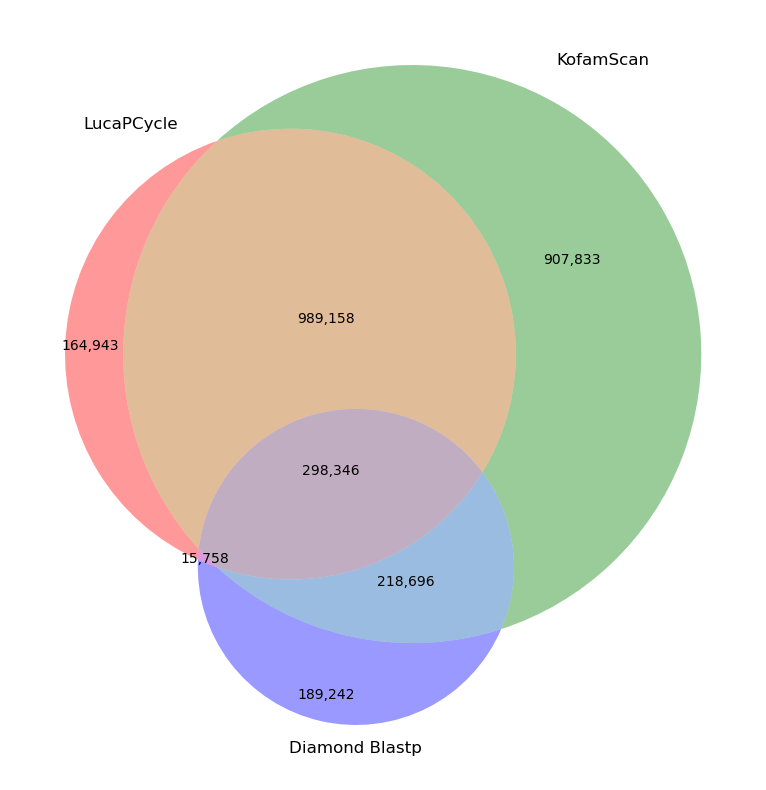

In [5]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

fig, ax = plt.subplots(figsize=(10, 10))

set_ai = all_ai_predicted_verify_seq_id_set
set_kofamscan = all_kofamscan_verify_seq_id_set
set_blastp = all_blastp_verify_seq_id_set


# 创建一个包含三个集合的字典，内容为每个集合的大小
sets = {
    '100': len(set_ai - set_kofamscan - set_blastp),
    '010': len(set_kofamscan - set_ai - set_blastp),
    '001': len(set_blastp - set_ai - set_kofamscan),
    '110': len(set_ai & set_kofamscan - set_blastp),
    '101': len(set_ai & set_blastp - set_kofamscan),
    '011': len(set_kofamscan & set_blastp - set_ai),
    '111': len(set_ai & set_kofamscan & set_blastp)
}

# 绘制韦恩图
venn3 = venn3(subsets=sets, set_labels=('LucaPCycle', 'KofamScan', 'Diamond Blastp'))

# 自定义每个区域的标签，以千分位显示
for subset_label in venn3.subset_labels:
    if subset_label:  # 检查标签是否存在（有时可能为空）
        # 更新标签文本，使用千分位格式化
        subset_label.set_text(f"{int(subset_label.get_text()):,}")
# 显示图表
plt.savefig("../Plot/pic/fig.lucapcycle_venn.png", dpi=600,  format='png')
plt.savefig("../Plot/pic/fig.lucapcycle_venn.pdf", dpi=600,  format='pdf')